## Data Exploration

In [1]:
from __future__ import division
import pymongo
import json
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
engine = create_engine('postgresql://lucka@localhost:5432/bugs')

### Check few lines

In [3]:
df_mini = pd.read_sql_query('select * from final limit 10',con=engine)
df_mini.head(2).T

,0,1
id,187257,187377
opening,2002-12-31 06:38:20,2003-01-01 14:49:54
reporter,17687,81611
current_status,resolved,resolved
current_resolution,fixed,duplicate
assigned_to_cnt,1,2
assigned_to_init,,font@layout.bugs
assigned_to_final,,blizzard@mozilla.org
bug_status_cnt,2,2
bug_status_init,new,unconfirmed


### Check Statistics

Load all data

In [4]:
df = pd.read_sql_query('select * from final',con=engine)

Sanity check

- Does `reports.current_resolution` correspond with the last `resolution.when`?
  - Yes, there are only 4 differences (all of them verified vs fixed, not a big deal)
- Does `reports.current_resolution` correspond with the last `bug_status.when`?
  - Mostly, there are 31 differences

In [5]:
df[df['resolution_final'] != df['current_resolution']]

,id,opening,reporter,current_status,current_resolution,assigned_to_cnt,assigned_to_init,assigned_to_final,bug_status_cnt,bug_status_init,...,severity_init,severity_final,short_desc_cnt,short_desc_init,short_desc_final,version_cnt,version_init,version_final,desc_init,closing
154284,6898,1999-05-21 10:10:06,3851,verified,fixed,1,,,5,new,...,major,major,1,ime bug-cannot move cursor to select the chara...,ime bug-cannot move cursor to select the chara...,1,trunk,trunk,Tested 5-21-09 Win32 build.\n\nStep of reprodu...,1999-07-07 06:37:43
195163,6429,1999-05-14 10:33:10,4346,verified,fixed,1,,,4,assigned,...,normal,normal,2,accountmanager.xul: non-localizable xul file,accountmanager.xul: non-localized xul file,1,trunk,trunk,"Please refer to the ""XUL Coding Style Guidelin...",1999-06-16 16:40:56
277316,7470,1999-06-02 09:00:08,4114,verified,fixed,6,ducarroz@netscape.com,tague@netscape.com,8,new,...,major,major,2,"[pp]linux only, backspace in compose area put ...","backspace in compose area put chinese word ""re...",1,trunk,trunk,Using 19990602008m7 build for linux on an HP V...,1999-06-08 08:07:27
318561,10359,1999-07-22 14:42:03,1689,verified,fixed,2,troy@netscape.com,dveditz@netscape.com,8,new,...,major,major,1,[8.3] raptor .dll names too long for win9x,[8.3] raptor .dll names too long for win9x,1,trunk,trunk,Raptor .DLL names need to be 8.3 on Win9x. Se...,1999-07-23 14:24:36


In [6]:
df[df['bug_status_final'] != df['current_status']]['id'].count()

31

Clean up

- calc duration
- remove enhancements
- unify priority ('--' > '')

In [7]:
df['duration'] = df['closing'] - df['opening']
df = df[df['severity_init'] != 'enhancement']
df['priority_init'] = df['priority_init'].map(lambda x: '' if x == '--' else x)
df['priority_final'] = df['priority_final'].map(lambda x: '' if x == '--' else x)

Explore dates

In [8]:
print df['opening'].min(), df['opening'].max()
print df['closing'].min(), df['closing'].max()

1996-03-11 07:00:00 2013-01-01 03:45:27
1998-08-27 05:56:51 2013-01-01 09:00:59


Look at overall statistics

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,310947,365961,220880,91,189293,352613,534812,825743
reporter,310947,156293,140354,1,20209,120380,282666,459470
assigned_to_cnt,310947,1.48021,0.840451,1,1,1,2,25
bug_status_cnt,310947,2.81843,1.30286,1,2,2,3,27
cc_cnt,310947,3.93562,5.78503,1,2,3,4,466
component_cnt,310947,1.28391,0.582393,1,1,1,1,13
op_sys_cnt,310947,1.11667,0.346803,1,1,1,1,7
priority_cnt,310947,1.10754,0.369123,1,1,1,1,9
product_cnt,310947,1.09418,0.335785,1,1,1,1,7
resolution_cnt,310947,2.20097,0.688984,1,2,2,2,20


### Reassignments

How much do bugs get reassigned to different priorities, components...?

In [10]:
total = len(df)
priority = sum(df['priority_init'] != df['priority_final'])
severity = sum(df['severity_init'] != df['severity_final'])
component = sum(df['component_init'] != df['component_final'])
product = sum(df['product_init'] != df['product_final'])

print '{} bugs in total'.format(total)
print ' {} ({:0.2f}%) bugs end up with different priority'.format(priority, priority*100/total)
print ' {} ({:0.2f}%) bugs end up with different severity'.format(severity, severity*100/total)
print ' {} ({:0.2f}%) bugs end up with different component'.format(component, component*100/total)
print ' {} ({:0.2f}%) bugs end up with different product'.format(product, product*100/total)

310947 bugs in total
 27319 (8.79%) bugs end up with different priority
 26028 (8.37%) bugs end up with different severity
 67343 (21.66%) bugs end up with different component
 24568 (7.90%) bugs end up with different product


### Unique Values (and Counts)

How many distinct values do we have for interesting attributes?

In [11]:
print '{} unique priorities'.format(df['priority_init'].nunique())
print '{} unique severities'.format(df['severity_init'].nunique())
print '{} unique components'.format(df['component_init'].nunique())
print '{} unique products'.format(df['product_init'].nunique())

6 unique priorities
7 unique severities
730 unique components
69 unique products


In [12]:
print 'values and counts for initial priority:'
print df['priority_init'].value_counts()

print 'values and counts for initial severity:'
print df['severity_init'].value_counts()

values and counts for initial priority:
      306187
p3      4483
p2       202
p1        53
p5        12
p4        10
Name: priority_init, dtype: int64
values and counts for initial severity:
normal      222705
major        32778
critical     28759
minor        16436
trivial       6719
blocker       3549
                 1
Name: severity_init, dtype: int64


Components are out of the game - there are too many.

Products could still be doable. What if we keep only top few products? How does it change the reassignment rate?

In [13]:
df['product_init'].value_counts().head(10)

core                         153369
firefox                      109664
thunderbird                   27645
bugzilla                      10437
browser                        2082
psm                            1418
webtools                       1375
mozilla application suite       800
mailnews                        624
mozilla.org                     421
Name: product_init, dtype: int64

In [14]:
top_products = ['core', 'firefox', 'thunderbird', 'bugzilla', 'browser', 'webtools', 'psm']
df['top_product_init'] = df['product_init'].map(lambda x: x if x in top_products else 'other')
df['top_product_final'] = df['product_final'].map(lambda x: x if x in top_products else 'other')

top_product = sum(df['top_product_init'] != df['top_product_final'])

print '{} bugs in total'.format(total)
print ' {} ({:0.2f}%) bugs end up with different product'.format(top_product, top_product*100/total)

310947 bugs in total
 24528 (7.89%) bugs end up with different product


### Duplicates

How many duplicates are there?

In [15]:
print 'final resolution - note the amount of duplicates:'
print df['resolution_final'].value_counts()

final resolution - note the amount of duplicates:
fixed         110143
duplicate      82770
worksforme     47813
invalid        34219
incomplete     21548
wontfix         9843
expired         4593
moved             14
                   4
Name: resolution_final, dtype: int64


### Resolution Time


In [16]:
df['duration_days'] = df['duration'].apply(lambda x: float(x.days))

In [17]:
df['duration_days'].describe().T

count    310947.000000
mean        206.352951
std         451.593985
min           0.000000
25%           0.000000
50%          16.000000
75%         183.000000
max        4767.000000
Name: duration_days, dtype: float64

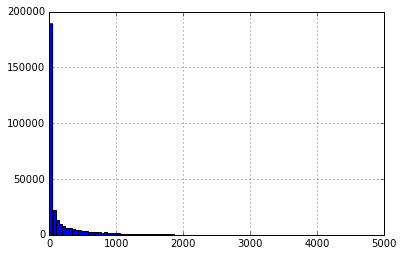

In [18]:
_ = df['duration_days'].hist(bins=100)

In [19]:
df['duration_bin'] = pd.cut(df['duration_days'], bins=[0,1,7,30,365,10000], right=True, labels=False)
#labels=['day','week','month','year','more']

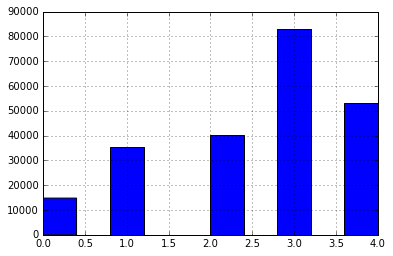

In [20]:
_ = df['duration_bin'].hist()

In [21]:
df['duration_bin'].value_counts()

3.0    82785
4.0    53125
2.0    40117
1.0    35255
0.0    14804
Name: duration_bin, dtype: int64